In [489]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd  
from sklearn import preprocessing
from sklearn.cluster import KMeans
import importlib
import os
import numpy as np
from skimage import measure
from ipywidgets import interact
from ipywidgets import interact_manual
from IPython.display import display
from ipywidgets import widgets

In [490]:
import ipynb.fs.full.wspFFA as wspFirefly
import ipynb.fs.full.wspCS as wspCuckooSearch
import ipynb.fs.full.wspKH as wspKrillHerd
import ipynb.fs.full.wspEHO as wspElephantHerding
import ipynb.fs.full.wspABC as wspArtificialBeeColony

import ipynb.fs.full.plotGraph as plotGraph
import ipynb.fs.full.wspMultithreshold as wspMultithreshold
import ipynb.fs.full.dicomHandler as dicomHandler

importlib.reload(wspFirefly)
importlib.reload(wspCuckooSearch)
importlib.reload(wspKrillHerd)
importlib.reload(wspElephantHerding)
importlib.reload(wspArtificialBeeColony)

importlib.reload(plotGraph)
importlib.reload(wspMultithreshold)
importlib.reload(dicomHandler)

<module 'ipynb.fs.full.dicomHandler' (/mnt/6884ACCB84AC9CD6/OneDrive - FEI/Aulas/Graduacao/8 - Semestre/CC8421 - TRABALHO FINAL DE CURSO II/image-segmentation/dicomHandler.ipynb)>

In [491]:
def plot_image_histogram(img, img2):
    plt.figure(figsize=(15, 5)) 
    plt.subplot(1,2,1)
    plt.imshow(img,cmap='gray')
    plt.title('image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(img2,cmap='gray')
    plt.title('image')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [492]:
folder_dir = "../Database/UsevillaBone/original/"
file = "CASE_20_1.npy"
bio_algorithms = 'FFA'
dimension = 1
q = 1

In [493]:
image = folder_dir + file

In [494]:
pixel_array = dicomHandler.read_npy_image(image)
print("Original:", pixel_array.min(), pixel_array.max())
transformed_pixel_array = dicomHandler.image_transformation(pixel_array)
print("Transformação:", transformed_pixel_array.min(), transformed_pixel_array.max())
original_image = pixel_array.copy()

hu_image = dicomHandler.transform_npy_to_hu(transformed_pixel_array)

hist, bin_edges, best_thresholds, img_thres = wspMultithreshold.wspMultithreshold(hu_image, bio_algorithms, dimension, q)

Original: -2000 3301
float64
Transformação: -2000 3301


In [495]:
high_intensity = wspMultithreshold.get_high_intensity_pixels(img_thres)

print(high_intensity.min(), high_intensity.max())

pixel_array = dicomHandler.transform_to_npy_pixel_array(high_intensity)

print(pixel_array.min(), pixel_array.max())

hard_tissue = wspMultithreshold.get_largests_regions(pixel_array, original_image)

print(hard_tissue.min(), hard_tissue.max())

-3024.0 2278.0
-3024.0 2278.0
-2000 3302
-2000 3302


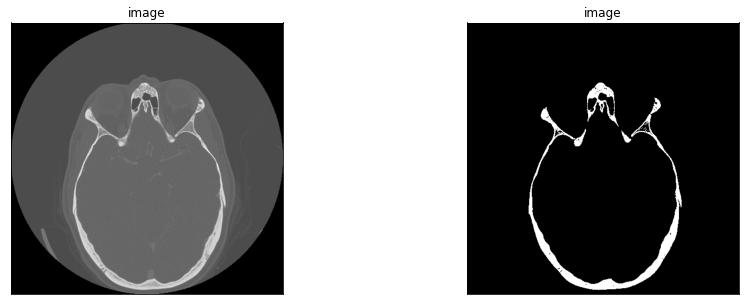

In [496]:
plot_image_histogram(hu_image, pixel_array)

In [497]:
min_val, max_val = original_image.min(), original_image.max()
print(min_val, max_val)

-2000 3301


In [498]:
org = original_image.copy()

In [499]:
mask = np.where(pixel_array==pixel_array.max(), False, True)

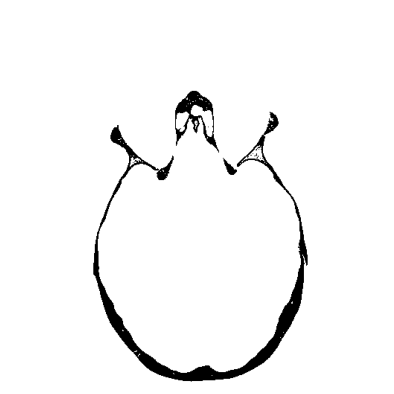

In [500]:
dicomHandler.show_dicom_image(mask)

In [501]:
org[mask] = org.max()

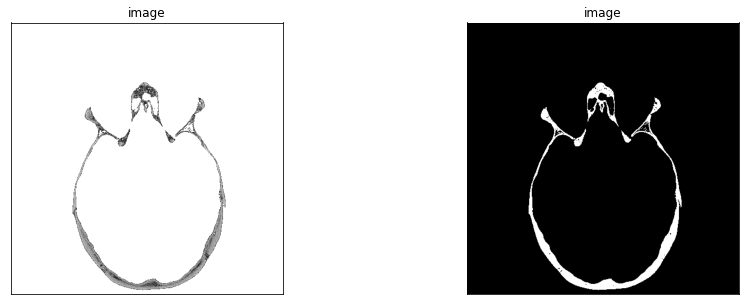

In [502]:
plot_image_histogram(org, pixel_array)

In [503]:
def region_stdev(region, intensities):
    return np.std(intensities[region])

In [504]:
def get_largest_region(pixel_array):
    max_value = pixel_array.max()
    min_value = pixel_array.min()

    labels_mask = measure.label(pixel_array, background=pixel_array.min())

    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)

    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = min_value

    labels_mask[labels_mask == 0] = min_value
    labels_mask[labels_mask != min_value] = max_value
    mask = labels_mask

    return mask.astype(np.int16)

In [505]:
def get_included_regions(pixel_array, original_image):
    label_image = measure.label(pixel_array, background=pixel_array.min())
    props = measure.regionprops_table(label_image, original_image, properties=['area', 'intensity_mean'], extra_properties=[region_stdev])
    
    table = pd.DataFrame(props)

    print(table)

    X_train = table.values.tolist()

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_scaled = scaler.transform(X_train)

    kmeans = KMeans(n_clusters=2, random_state=0).fit(X_scaled)
    clusters = kmeans.labels_

    print(clusters[table['area'].idxmax()])
    print(clusters)

    return clusters[table['area'].idxmax()], clusters

In [506]:
def get_largests_regions(pixel_array, original_image):
    max_value = pixel_array.max()
    min_value = pixel_array.min()
    
    labels_mask = measure.label(pixel_array, background=pixel_array.min())

    regions = measure.regionprops(labels_mask)

    if len(regions) > 1:
        big_reg_cluster, clusters = get_included_regions(pixel_array, original_image)
        for index in range(len(regions)):
            if clusters[index] != big_reg_cluster:
                labels_mask[regions[index].coords[:,0], regions[index].coords[:,1]] = min_value

    labels_mask[labels_mask == 0] = min_value
    labels_mask[labels_mask != min_value] = max_value
    mask = labels_mask

    return mask.astype(np.int16)

In [507]:
final_mask = get_largests_regions(pixel_array, original_image)

    area  intensity_mean  region_stdev
0   1507     2359.920372    295.218813
1   8521     2550.170403    291.416429
2      1     1827.000000      0.000000
3      1     1974.000000      0.000000
4      1     1892.000000      0.000000
5      1     1834.000000      0.000000
6      5     1885.000000     71.007042
7      2     1900.000000     48.000000
8      1     1900.000000      0.000000
9      5     1908.600000     88.294054
10   167     2305.964072    302.959492
11     1     1852.000000      0.000000
12     1     1895.000000      0.000000
1
[1 1 0 0 0 0 0 0 0 0 1 0 0]


In [508]:
final_mask

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

In [509]:
pixel_array

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

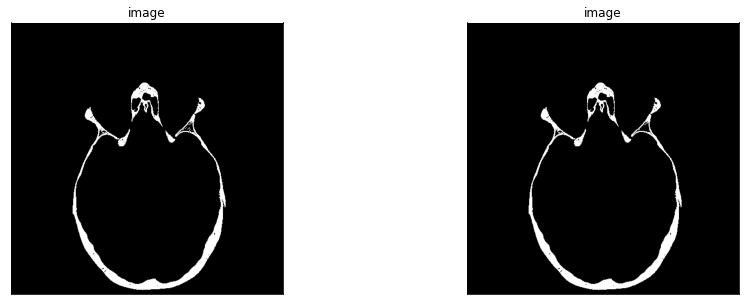

In [510]:
plot_image_histogram(pixel_array, final_mask)